# W10 - October 25 - Statistics and Optimization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats
from scipy import optimize

%matplotlib inline

## Measures of central tendency

In [2]:
observations = np.random.uniform(low=0, high=200, size=1000)
np.mean(observations)

96.26694093698472

The **median** is more robust as it is less sensitive to outliers.

In [3]:
np.median(observations)

92.71944116035468

In [4]:
observations_outlier = np.append(observations, [1239, 1982, 1647])
print(f"Mean: {np.mean(observations_outlier)} \t Median: {np.median(observations_outlier)}.")

Mean: 100.83244360616622 	 Median: 94.50479943852608.


The median is the same as the 50th **percentile**.

In [5]:
stats.scoreatpercentile(observations, 50)

92.71944116035468

Similarly, for any other percentile:

In [6]:
stats.scoreatpercentile(observations, 95)     

189.74005161865344

### With `pandas`

In [7]:
iris = sns.load_dataset("iris")
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [8]:
iris.mean(numeric_only=True)

sepal_length    5.843333
sepal_width     3.057333
petal_length    3.758000
petal_width     1.199333
dtype: float64

In [9]:
iris["petal_length"].mean()

3.7580000000000027

In [10]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### Pearson's correlation coefficient

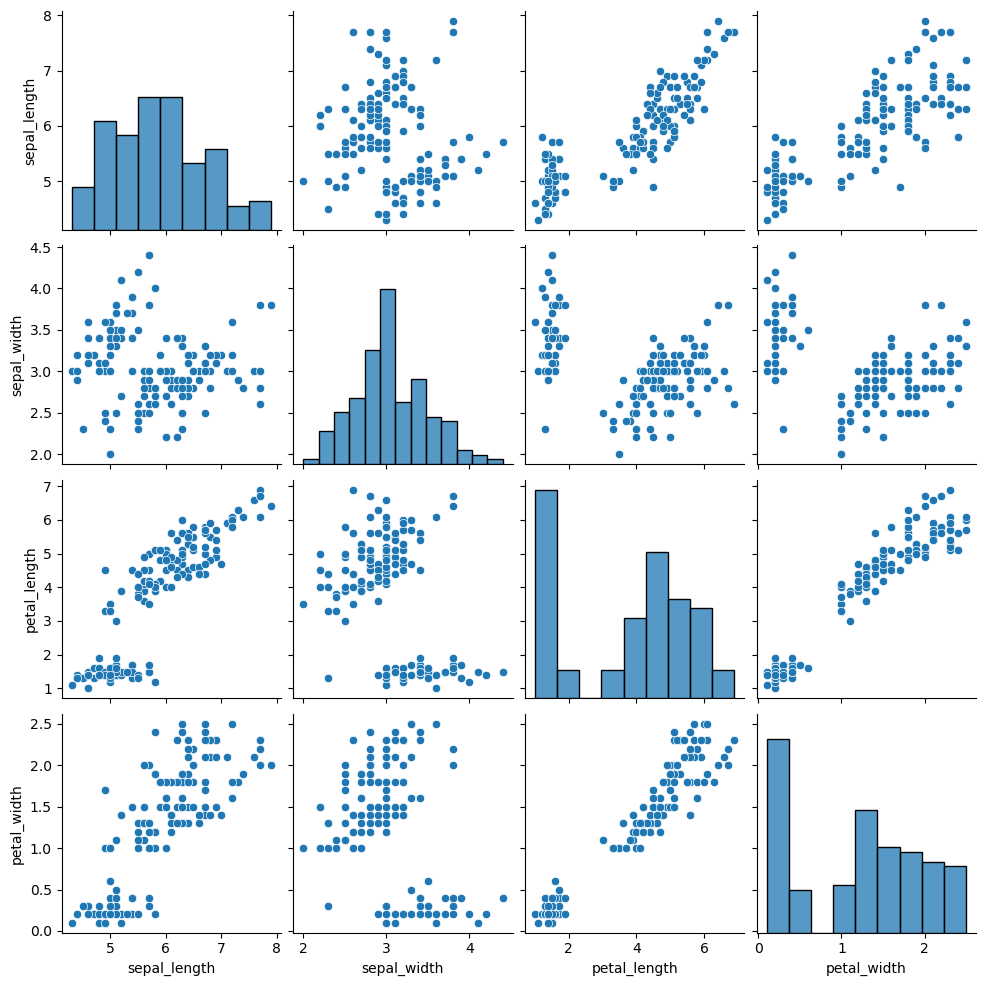

In [11]:
sns.pairplot(iris);

In [12]:
stats.pearsonr(iris["petal_length"], iris["petal_width"])  # Returns correlation coefficient and p-value

PearsonRResult(statistic=0.9628654314027961, pvalue=4.6750039073275495e-86)

There's a pretty high correlation between the petal length and width.

Quite the opposite for the sepal length and width.

In [13]:
stats.pearsonr(iris["sepal_length"], iris["sepal_width"])  # Returns correlation coefficient and p-value

PearsonRResult(statistic=-0.11756978413300205, pvalue=0.15189826071144918)

## A common pitfall

In [14]:
anscombe = sns.load_dataset("anscombe")  # Anscombe's quartet
with pd.option_context('display.max_rows',10):  # to print 5 head and 5 tail rows.
    print(anscombe)  # Note that the printed format is different when using print() and when using Jupyter's display

   dataset     x      y
0        I  10.0   8.04
1        I   8.0   6.95
2        I  13.0   7.58
3        I   9.0   8.81
4        I  11.0   8.33
..     ...   ...    ...
39      IV   8.0   5.25
40      IV  19.0  12.50
41      IV   8.0   5.56
42      IV   8.0   7.91
43      IV   8.0   6.89

[44 rows x 3 columns]


All 4 datasets have the same mean:

In [15]:
anscombe_grouped = anscombe.groupby("dataset")
anscombe_grouped.mean()

,x,y
dataset,,
I,9.0,7.500909
II,9.0,7.500909
III,9.0,7.500000
IV,9.0,7.500909


and the same standard deviation:

In [16]:
anscombe_grouped.std()

,x,y
dataset,,
I,3.316625,2.031568
II,3.316625,2.031657
III,3.316625,2.030424
IV,3.316625,2.030579


Further, the correlation between `x` and `y` is the same for all four datasets:

In [17]:
def get_group_cor(df):
    """Returns Pearson's correlation coefficient between x and y for the DataFrame."""
    return stats.pearsonr(df["x"], df["y"])[0]


anscombe_grouped.apply(get_group_cor)

dataset
I      0.816421
II     0.816237
III    0.816287
IV     0.816521
dtype: float64

and a linear regression on each dataset results in the same fit, with the same $R^2$.

In [18]:
def get_group_regression(df):
    """Returns a string with 1st degree linear regression fit between x and y, and the R2 value."""
    x = df["x"]
    y = df["y"]
    
    # Using numpy.polyfit to fit 1st degree polynomial
    fit_result = np.polyfit(x, y, deg=1, full=True)  # full=True also gives us the sum of squared residuals, as well as other metrics.
    coeffs = fit_result[0]
    
    # Calculating R^2. We will see a better way to do this with SciPy in the next class
    ss_res = fit_result[1][0]
    y_mean = np.mean(y)
    ss_tot = np.sum((y - y_mean)**2)
    r2 = 1 - (ss_res / ss_tot)
    
    return f"Fit: y = {coeffs[0]:.2f}x + {coeffs[1]:.2f}    R2: {r2:.4f}"


anscombe_grouped.apply(get_group_regression)

dataset
I      Fit: y = 0.50x + 3.00    R2: 0.6665
II     Fit: y = 0.50x + 3.00    R2: 0.6662
III    Fit: y = 0.50x + 3.00    R2: 0.6663
IV     Fit: y = 0.50x + 3.00    R2: 0.6667
dtype: object

But the data in all four datasets are vastly different!

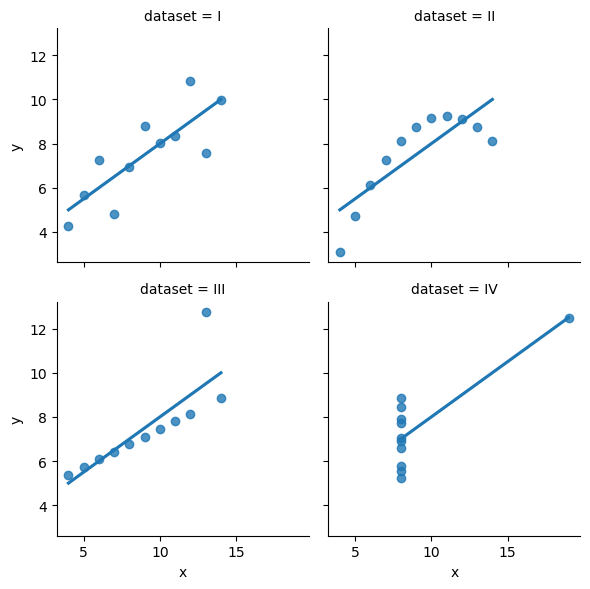

In [19]:
sns.lmplot(x="x", y="y", data=anscombe,
           col="dataset", col_wrap=2,  # wrap the column variable to multiple rows, each row having 2 columns
           ci=None, height=3);

***Takeaway:* It's always a good idea to plot your data before performing any analysis.**

## Distributions

In [20]:
observations = np.random.normal(loc=100, scale=2, size=5000)
hist, bins = np.histogram(observations, bins=25, density=True)
hist, bins

(array([0.00032961, 0.00065923, 0.00065923, 0.00164807, 0.00527382,
        0.01153648, 0.02208411, 0.04284977, 0.07383345, 0.09328066,
        0.14634845, 0.18359479, 0.17865059, 0.21029349, 0.18656131,
        0.15887377, 0.12393472, 0.08504032, 0.05240857, 0.03460943,
        0.02010643, 0.00922918, 0.00296652, 0.00197768, 0.00131845]),
 array([ 91.90997928,  92.51675031,  93.12352134,  93.73029237,
         94.3370634 ,  94.94383443,  95.55060546,  96.15737649,
         96.76414752,  97.37091855,  97.97768958,  98.58446061,
         99.19123164,  99.79800266, 100.40477369, 101.01154472,
        101.61831575, 102.22508678, 102.83185781, 103.43862884,
        104.04539987, 104.6521709 , 105.25894193, 105.86571296,
        106.47248399, 107.07925501]))

In [21]:
len(hist), len(bins)

(25, 26)

In [22]:
bin_centers = 0.5*(bins[:-1] + bins[1:])  # each value is ( bin(i) + bin(i+1) ) / 2, up to i-1
bin_centers

array([ 92.2133648 ,  92.82013583,  93.42690686,  94.03367789,
        94.64044892,  95.24721995,  95.85399097,  96.460762  ,
        97.06753303,  97.67430406,  98.28107509,  98.88784612,
        99.49461715, 100.10138818, 100.70815921, 101.31493024,
       101.92170127, 102.5284723 , 103.13524332, 103.74201435,
       104.34878538, 104.95555641, 105.56232744, 106.16909847,
       106.7758695 ])

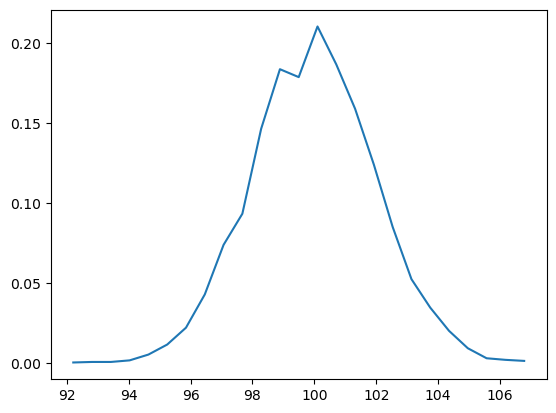

In [23]:
plt.plot(bin_centers, hist);

**`stats.norm.fit()`** can be used to estimate the parameters of the distribution.

In [24]:
loc, std = stats.norm.fit(observations)
loc, std

(99.96908423976504, 1.9817513974255536)

### With `pandas` Series:

In [25]:
stats.norm.fit(iris["sepal_width"])

(3.0573333333333337, 0.4344109677354946)

In [26]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


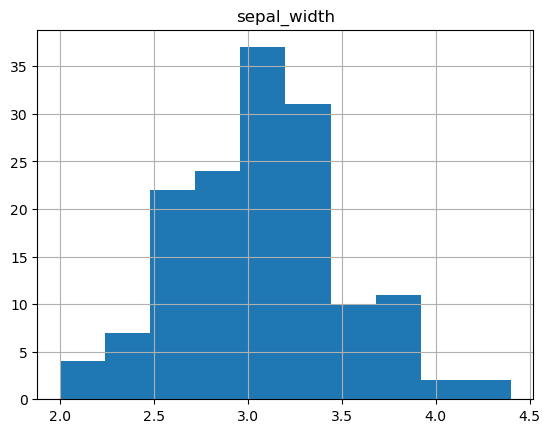

In [27]:
iris.hist(column="sepal_width");

## Hypothesis testing

### 1 sample students' t-test

`scipy.stats.ttest_1samp()` tests for the null hypothesis that the expected value (mean) of a sample of independent observations `a` is equal to the given population mean, `popmean`.

In other words, test if the population mean of data is likely to be equal to a given value. Since a normal distribution is the underlying assumption for this test, we are technically testing if observations are drawn from a Gaussian distribution of given population mean.

**Null hypothesis: Mean of sepal_width is 2.**

In [28]:
stats.ttest_1samp(a=iris['sepal_width'], popmean=2)   

Ttest_1sampResult(statistic=29.71011115345717, pvalue=1.741576256487317e-64)

The function returns the t-statistic, and the p-value.

With a `pvalue` that is practically 0, we reject the null hypothesis in favor of the *default “two-sided” alternative*: the mean of sepal_width is not 2.

**Null hypothesis: Mean of sepal_width is 3.**

In [29]:
stats.ttest_1samp(a=iris['sepal_width'], popmean=3)

Ttest_1sampResult(statistic=1.6110148544749883, pvalue=0.10929285667458065)

With a standard threshold of 0.05 (95%), we can say that we fail to reject the null hypothesis.

We can say, with ~89% confidence that the mean of sepal_width is 3.

**Null hypothesis: Mean of sepal_width is 4.**

**Alternative hypothesis: Mean of sepal_width is less than 4.**

In [30]:
stats.ttest_1samp(a=iris['sepal_width'], popmean=4, alternative="less")   

Ttest_1sampResult(statistic=-26.488081444507195, pvalue=1.5557171975800779e-58)

We reject the null hypothesis in favor of the defined “less” alternative: the mean of sepal_width is less than 4.

### 2 sample students' t-test

`scipy.stats.ttest_ind()` tests for the null hypothesis that 2 independent samples, `a` and `b`, have identical average values. This test assumes that the populations have identical variances by default.

In other words, to test if the differences between the 2 samples is significant.

In [31]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [32]:
iris.groupby("species").count()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,50,50,50,50
versicolor,50,50,50,50
virginica,50,50,50,50


In [33]:
iris_setosa = iris[iris["species"] == "setosa"]
iris_setosa.reset_index(inplace=True, drop=True)
iris_setosa.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [34]:
iris_versicolor = iris[iris["species"] == "versicolor"]
iris_versicolor.reset_index(inplace=True, drop=True)
iris_versicolor.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,7.0,3.2,4.7,1.4,versicolor
1,6.4,3.2,4.5,1.5,versicolor
2,6.9,3.1,4.9,1.5,versicolor
3,5.5,2.3,4.0,1.3,versicolor
4,6.5,2.8,4.6,1.5,versicolor


In [35]:
iris_virginica = iris[iris["species"] == "virginica"]
iris_virginica.reset_index(inplace=True, drop=True)
iris_virginica.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,6.3,3.3,6.0,2.5,virginica
1,5.8,2.7,5.1,1.9,virginica
2,7.1,3.0,5.9,2.1,virginica
3,6.3,2.9,5.6,1.8,virginica
4,6.5,3.0,5.8,2.2,virginica


In [36]:
iris.groupby("species").mean()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


**Null hypothesis: Versicolor and Virginica have identical petal lengths**

By default, this test assumes that the populations have identical variances.

In [58]:
stats.ttest_ind(iris_versicolor["petal_length"], iris_virginica["petal_length"], equal_var=False)

Ttest_indResult(statistic=-12.603779441384987, pvalue=4.900287527398095e-22)

With a `pvalue` that is practically 0, we reject the null hypothesis in favor of the *default “two-sided” alternative*: the means of petal_length for the two species are not identical.

**Null hypothesis: Versicolor and Setosa have identical petal lengths**

**Alternative hypothesis: The mean petal length of Versicolor (first sample) is *greater than* the mean petal length of Setosa (second sample).**

In [ ]:
stats.ttest_ind(iris_versicolor["petal_length"], iris_setosa["petal_length"], alternative="lesser", equal_var=False)

We reject the null hypothesis in favor of the defined “greater” alternative: the mean petal_length of Versicolor is greater than the mean petal_length of Setosa.

***Note:*** T-tests assume Gaussian errors. The Mann–Whitney U test (`scipy.stats.mannwhitneyu()`) relaxes this assumption.

### Paired tests

In the above tests, the observations were independent. Sometimes, there are links between observations, e.g., if the two datasets are two sets of observations on the same individuals. In this case, the variance due to inter-subject variability is confounding, and can be removed, using a “paired test”, or “repeated measures test”.

In [39]:
# Specify how to the missing value (NA) so we can do statistical analysis.
df_brain = pd.read_csv('brain_size.csv', sep=';', na_values=".")
df_brain.head()

,Unnamed: 0,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
0,1,Female,133,132,124,118.0,64.5,816932
1,2,Male,140,150,124,NaN,72.5,1001121
2,3,Male,139,123,150,143.0,73.3,1038437
3,4,Male,133,129,128,172.0,68.8,965353
4,5,Female,137,132,134,147.0,65.0,951545


In the dataset above, FSIQ and PIQ are measured on the same individuals.

**Null hypothesis: The FSIQ and PIQ samples have identical average (expected) values.**

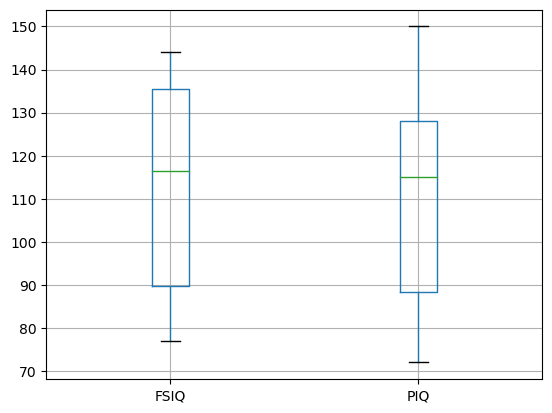

In [40]:
df_brain.boxplot(column=['FSIQ', 'PIQ']);

In [41]:
stats.ttest_rel(df_brain['FSIQ'], df_brain['PIQ'])

Ttest_relResult(statistic=1.7842019405859857, pvalue=0.08217263818364236)

This is equivalent to a 1-sample test.

**Null hypothesis: The difference between the means of the FSIQ and PIQ samples is 0.**

In [42]:
stats.ttest_1samp(df_brain['FSIQ'] - df_brain['PIQ'], 0)

Ttest_1sampResult(statistic=1.7842019405859857, pvalue=0.08217263818364236)

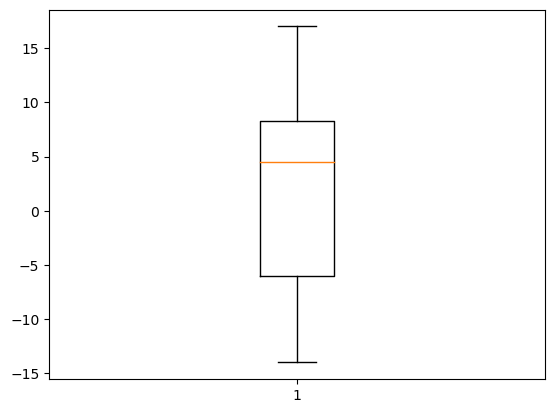

In [43]:
plt.boxplot(df_brain['FSIQ'] - df_brain['PIQ']);

***Note:*** T-tests assume Gaussian errors. The Wilcoxon signed-rank test (`scipy.stats.wilcoxon()`) relaxes this assumption.

## Optimization

To find the minima of a function.

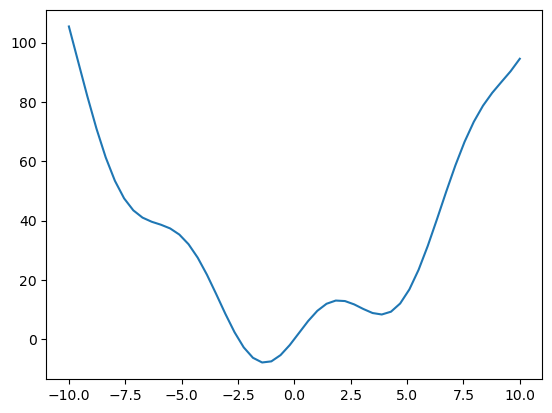

In [44]:
def f(x):
    return x**2 + 10*np.sin(x)

x = np.linspace(-10, 10)
plt.plot(x, f(x));

In [45]:
result = optimize.minimize(f, x0=0)
result

      fun: -7.945823375615215
 hess_inv: array([[0.08589237]])
      jac: array([-1.1920929e-06])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([-1.30644012])

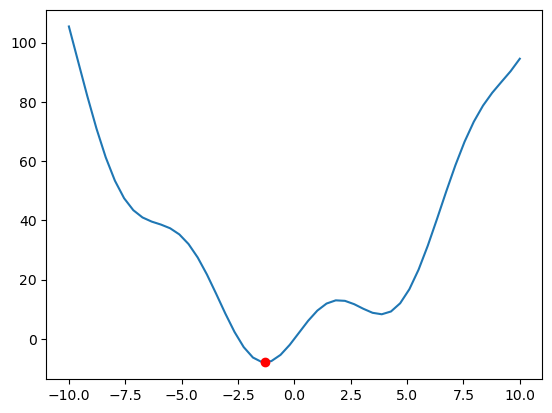

In [46]:
plt.plot(x, f(x))
plt.plot(result.x, result.fun, "ro");

The minimize algorithm is sensistive to the initial point `x0`, and choosing a "wrong" `x0` can lead the function to a local minima.

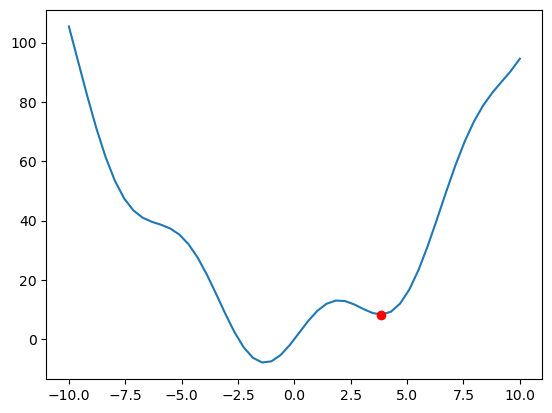

In [47]:
result = optimize.minimize(f, x0=8)
plt.plot(x, f(x))
plt.plot(result.x, result.fun, "ro");

**Global optimization**

Having an idea of your function can help you choose the "right" `x0`. 

However, if you don’t know the neighborhood of the global minimum, a costlier global optimization needs to be performed. `scipy.optimize.basinhopping()` combines a local optimizer with sampling of starting points.

In general, knowing your problem will help you a great deal in choosing the right tool, such as the function, initial guess, and `method` for the minimization.

For more details, see https://scipy-lectures.org/advanced/mathematical_optimization/index.html

### Optimization with constraints

We can constrain the optimization variable with `bounds`:

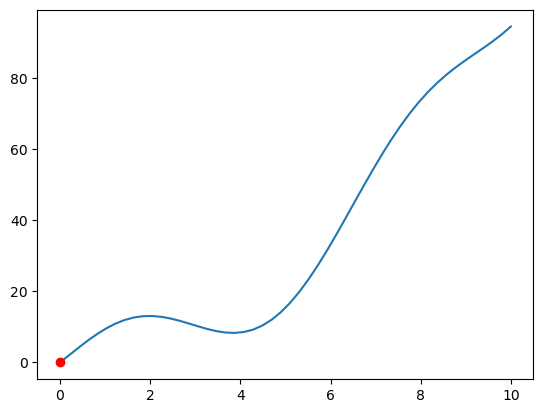

In [48]:
result = optimize.minimize(f, x0=1, bounds=((0, 10), ))
x = np.linspace(0, 10)
plt.plot(x, f(x))
plt.plot(result.x, result.fun, "ro");

***Note:*** `scipy.optimize.minimize_scalar()` is a function with dedicated methods to minimize functions of only one variable.

### Roots

i.e., find where $f(x) = 0$

In [49]:
root_1 = optimize.root(f, x0=1)
root_1

    fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([1.33310463e-32])
       r: array([-10.])
  status: 1
 success: True
       x: array([0.])

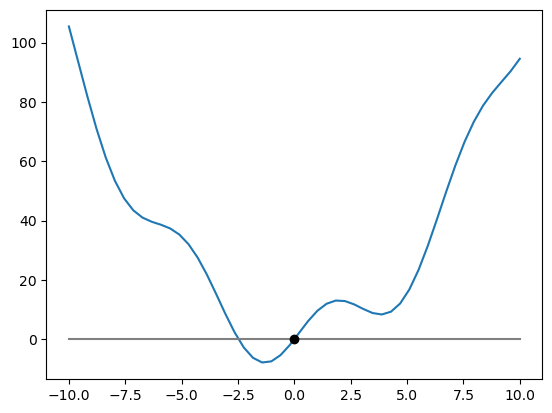

In [50]:
x = np.linspace(-10, 10)
plt.plot(x, f(x))
plt.plot([-10, 10], [0, 0], "gray")
plt.plot(root_1.x, root_1.fun, "ko");

Similar to `minimize()`, `root()` only finds one solution based on the initial guess `x0`.

In [51]:
root_2 = optimize.root(f, x0=-3)
root_2

    fjac: array([[-1.]])
     fun: array([-1.77635684e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-2.83790769e-11])
       r: array([12.84592704])
  status: 1
 success: True
       x: array([-2.47948183])

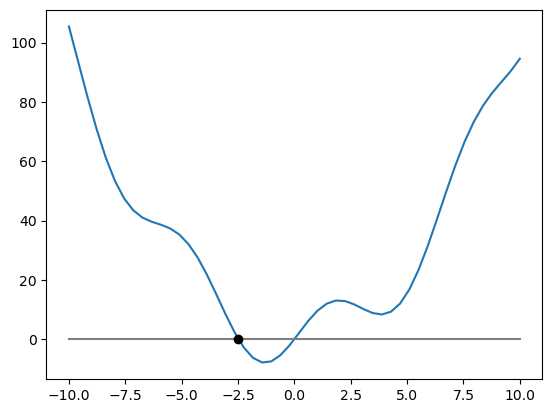

In [52]:
plt.plot(x, f(x))
plt.plot([-10, 10], [0, 0], "gray")
plt.plot(root_2.x, root_2.fun, "ko");

### Curve fitting

The `scipy.optimize` toolbox can also be used to optimize the parameters for a function.

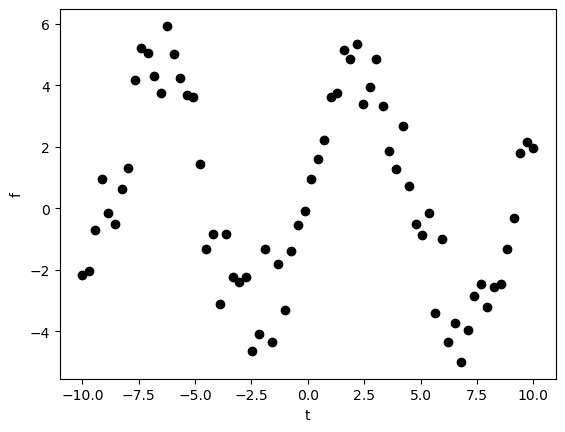

In [53]:
time = np.linspace(-10, 10, num=70)
signal = 4.2 * np.sin(0.7*time) + np.random.normal(size=70)  # a=4.2, omega=0.7
plt.plot(time, signal, "ok")
plt.xlabel("t")
plt.ylabel("f");

We know the data is in the form $f = a \text{ sin}(\omega t)$

In [54]:
def test_func(x, m, c):
    return m*x + c

popt_1, pcov_1 = optimize.curve_fit(test_func, time, signal, p0=(1, 1))
popt_1, pcov_1

(array([-0.11840355,  0.37468245]),
 array([[3.72756491e-03, 1.53837346e-11],
        [1.53837346e-11, 1.27853675e-01]]))

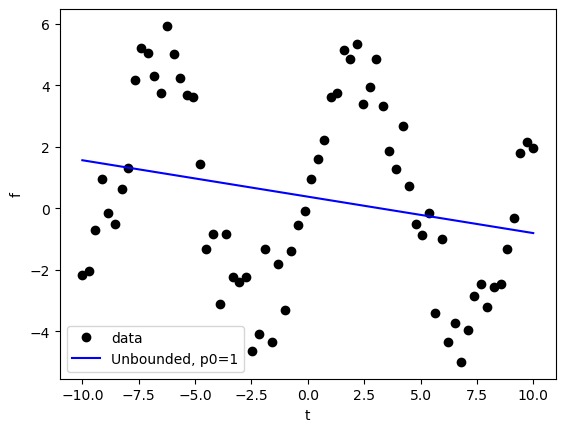

In [55]:
plt.plot(time, signal, "ok", label="data")
plt.plot(time, test_func(time, *popt_1), 'b-', label="Unbounded, p0=1")
plt.xlabel("t")
plt.ylabel("f")
plt.legend();

As with everything with optimization, the initial guess `p0` and `bounds` are important.

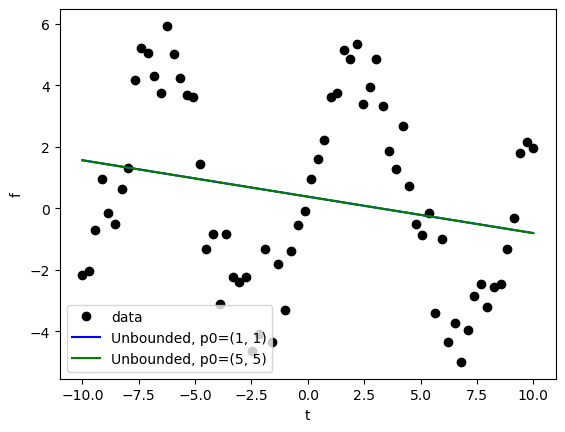

In [56]:
popt_2, pcov_2 = optimize.curve_fit(test_func, time, signal, p0=(5, 5))

plt.plot(time, signal, "ok", label="data")
plt.plot(time, test_func(time, *popt_1), 'b-', label="Unbounded, p0=(1, 1)")
plt.plot(time, test_func(time, *popt_2), 'g-', label="Unbounded, p0=(5, 5)")
plt.xlabel("t")
plt.ylabel("f")
plt.legend();

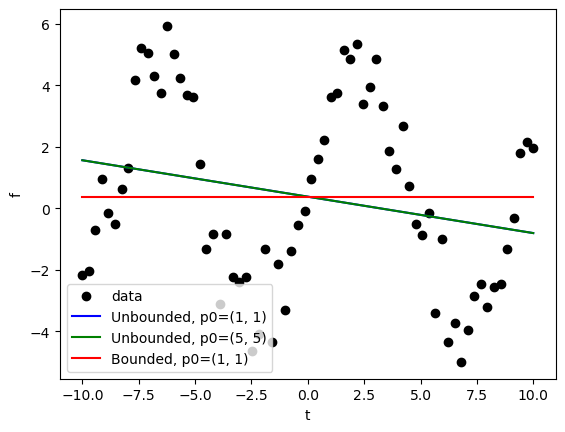

In [57]:
popt_3, pcov_3 = optimize.curve_fit(test_func, time, signal, p0=(1, 1), bounds=(0, [3, 1]))  # bounds of (0, 3) for a; and (0, 1) for omega

plt.plot(time, signal, "ok", label="data")
plt.plot(time, test_func(time, *popt_1), 'b-', label="Unbounded, p0=(1, 1)")
plt.plot(time, test_func(time, *popt_2), 'g-', label="Unbounded, p0=(5, 5)")
plt.plot(time, test_func(time, *popt_3), 'r-', label="Bounded, p0=(1, 1)")

plt.xlabel("t")
plt.ylabel("f")
plt.legend();